In [1]:
import sqlite3
import pandas as pd
import numpy as np

conn = sqlite3.connect("../exp/narma10_100/fitness.db")
narma10_100_fit_df = pd.read_sql_query("SELECT * FROM fitness;", conn)
narma10_100_models_df = pd.read_sql_query("SELECT * FROM models;", conn)
conn.close()

conn = sqlite3.connect("../exp/narma10_200/fitness.db")
narma10_200_fit_df = pd.read_sql_query("SELECT * FROM fitness;", conn)
narma10_200_models_df = pd.read_sql_query("SELECT * FROM models;", conn)
conn.close()

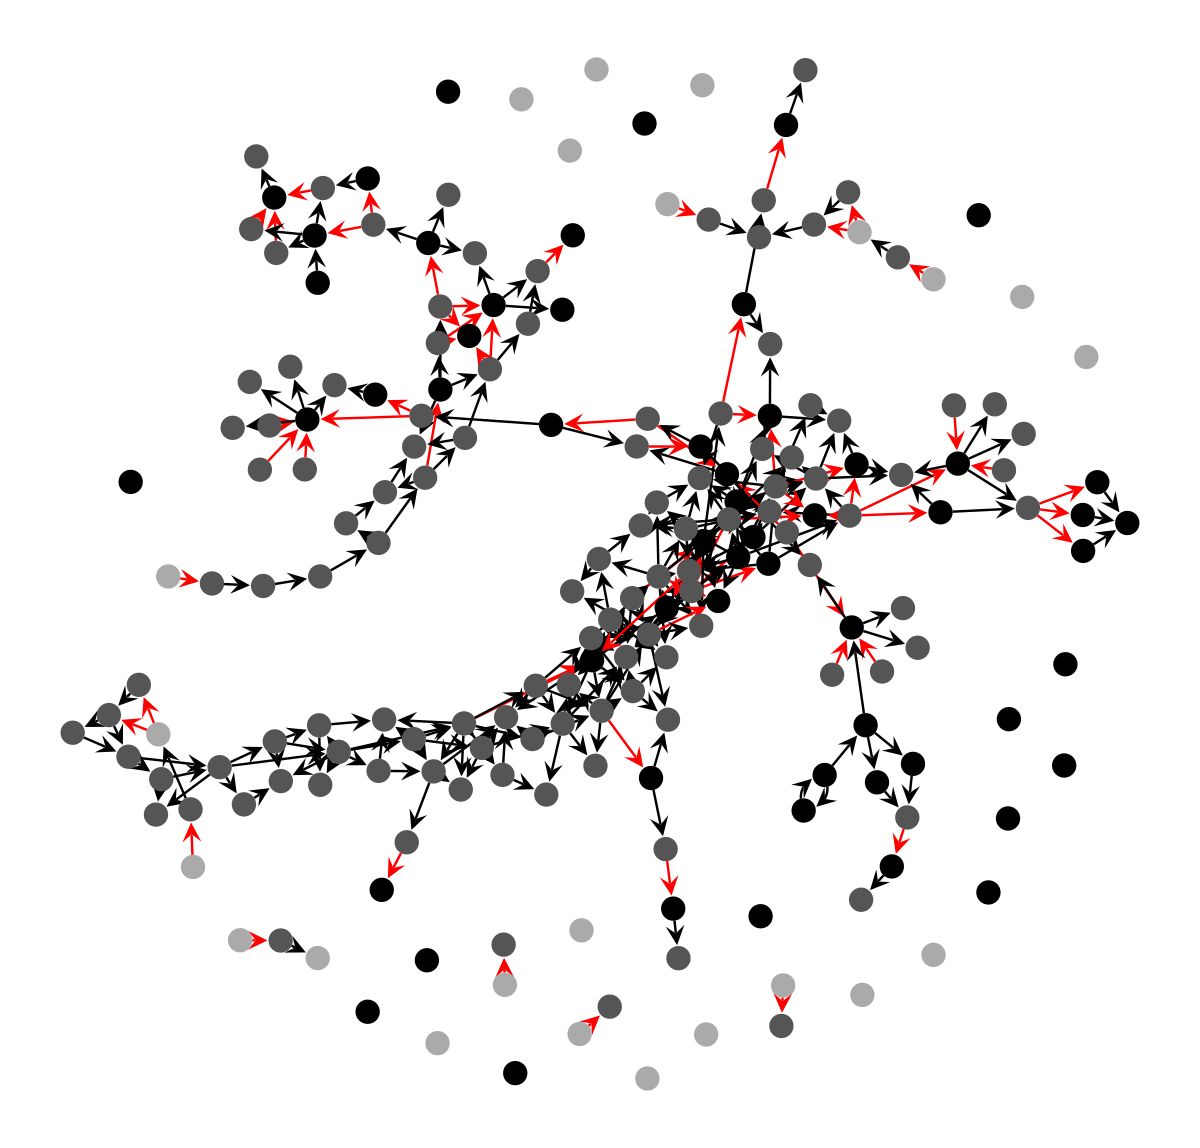

fitness: 0.11392857913275192
size: 198


In [ ]:
import sys
sys.path.append("../")
import jsonpickle
from grow.reservoir import Reservoir
from measure.metrics import get_metrics
from measure.tasks import narmax

run_id = 41
epoch = -1

reservoir_encoded = narma10_200_models_df.loc[(narma10_200_models_df["run_id"] == run_id) & (narma10_200_models_df["epoch"] == epoch), "reservoir"].values[0]
reservoir_decoded = jsonpickle.decode(reservoir_encoded)

reservoir_decoded.bipolar().draw_gt()

Error: 0.11532830277056508


/opt/homebrew/Caskroom/miniconda/base/envs/dgca_tasks/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 4 in image.
/opt/homebrew/Caskroom/miniconda/base/envs/dgca_tasks/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: methods/narma10_200_run1_prediction.pdf


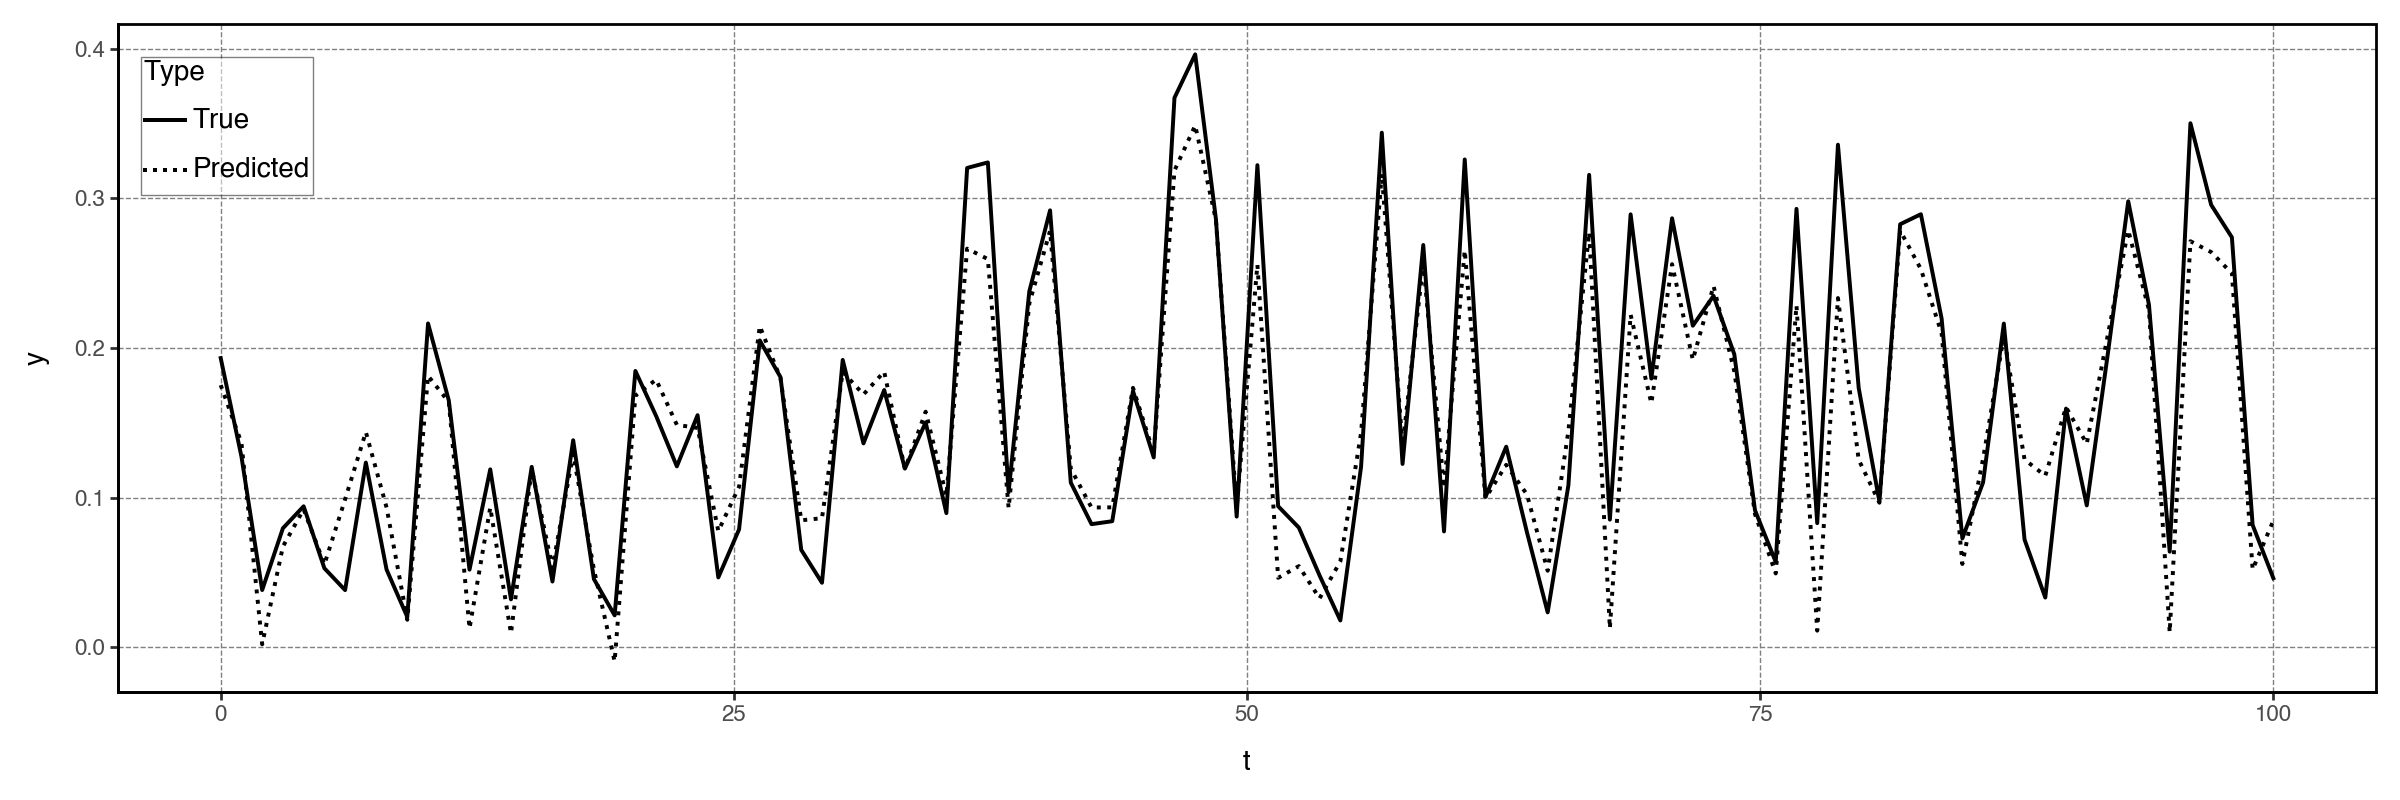

In [ ]:
import sys
sys.path.append("../")
import jsonpickle
from grow.reservoir import Reservoir
from measure.tasks import narmax
from plotnine import *
from plotnine import options

options.figure_size = (12, 4)

prediction_theme = theme(
    plot_title=element_text(size=14, weight="bold"),  
    axis_title_x=element_text(size=10),  
    axis_title_y=element_text(size=10),  
    axis_text_x=element_text(size=8),  
    axis_text_y=element_text(size=8),  

    panel_border=element_rect(fill=None, color="black"),
    
    legend_title=element_text(size=10, weight="bold"),  
    legend_text=element_text(size=10),  
    legend_background=element_rect(fill="white", color="black", alpha=0.5, size=0.5),
    
    legend_position=(0.01, 0.95),  
    legend_justification=(0, 1),  
    panel_grid_major=element_line(color="grey", size=0.5, linetype="--")
    
)


u, y = narmax()
reservoir_decoded.reset()
y_hat = reservoir_decoded.train(u, y)

error = np.mean(((y[:, 20:] - y_hat) ** 2) / np.var(y))
print("Error:", error)

y = y[:, 20:]

scale = 100
x = np.linspace(0, scale, scale)

df = pd.DataFrame({
    "Time Step": np.tile(x, 2),  
    "Value": np.concatenate([y[0, :scale], y_hat[0, :scale]]),
    "Type": ["True"] * scale + ["Predicted"] * scale  
})

df["Type"] = pd.Categorical(df["Type"], categories=["True", "Predicted"], ordered=True)

g = (
    ggplot(df)
    + geom_line(aes(x="Time Step", y="Value", color="Type", linetype="Type"), size=0.8)
    + scale_color_manual(values={"True": "black", "Predicted": "black"})
    + scale_linetype_manual(values={"True": "-", "Predicted": ":"})
    + labs(
        x="t",
        y="y"
    )
    + theme_classic()
    + prediction_theme
)

g.save("methods/narma10_200_run1_prediction.pdf", width=12, height=4, dpi=1000, bbox_inches='tight')
g